In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
# 입력 Layer로 사용되는 Flatten layer, 출력, hidden layer로 사용되는 Dense layer
from tensorflow.keras.layers import Flatten, Dense
# Convolution, Pooling, Dropout-overfitting을 막기위함
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# Raw Data Loading
df = pd.read_csv('/content/drive/MyDrive/Colab임시폴더/mnist/train.csv')
display(df.head())

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# 데이터 전처리
# 결측치, 이상치, 정규화, feature engineering

# 우리 예제는 결측치, 이상치가 없다!
# 대신 정규화는 필요하다!

# train data와 test data를 분리할 필요가 있다!
# 학습을 하기 위한 train data
# 이 train data는 학습을 위한 train data와 validation data로 분리

# 마지막 평가를 하기 위해 딱 1번 사용되는 test data
# 이 두개로 분리해야 한다!
train_x_data, test_x_data, train_t_data, test_t_data = \
train_test_split(df.drop('label', axis=1, inplace=False),
                 df['label'],
                 test_size=0.3,
                 random_state=1,
                 stratify=df['label'])

scaler = MinMaxScaler()
scaler.fit(train_x_data)
norm_train_x_data = scaler.transform(train_x_data)
norm_test_x_data = scaler.transform(test_x_data)

# t_data에 대한 one-hot encoding 처리는 하지 않아도 된다!(keras 설정을 잡아서 이용)

In [4]:
# Keras 구현
# model 구현
model = Sequential()

model.add(Conv2D(filters=32,
                 kernel_size=(3,3),   # filter size
                 activation='relu',
                 input_shape=(28,28,1),   # 입력 image size, filter 개수
                 padding='valid',   # 원본에서 사이즈가 줄어든다.
                 strides=(1,1)))

model.add(MaxPooling2D(pool_size=(2,2)))  # stride는 알아서 pool_size와 동일하게 잡는다.

# print(model.summary())   # 내가 만든 모델의 요약정보를 볼 수 있다.

model.add(Conv2D(filters=64,
                 kernel_size=(3,3),   # filter size
                 activation='relu',
                 # 입력으로 들어오는 값을 알아서 처리 -> input_shape 명시가 필요 없다.
                 padding='valid',   # 원본에서 사이즈가 줄어든다.
                 strides=(1,1)))

model.add(MaxPooling2D(pool_size=(2,2)))  # stride는 알아서 pool_size와 동일하게 잡는다.

model.add(Conv2D(filters=64,
                 kernel_size=(3,3),   # filter size
                 activation='relu',
                 # 입력으로 들어오는 값을 알아서 처리 -> input_shape 명시가 필요 없다.
                 padding='valid',   # 원본에서 사이즈가 줄어든다.
                 strides=(1,1)))

# print(model.summary())

model.add(Flatten())
model.add(Dropout(rate=0.5))   # 형태는 유지하되 연산을 수행하는 노드를 반으로 줄인다.
model.add(Dense(units=256,   # 256개의 node를 가지는 hidden layer
                activation='relu'))

model.add(Dense(units=10,   # 10개의 Class(node)를 가지는 Output layer
                activation='softmax'))

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 576)               0

In [5]:
# model 실행 옵션
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [6]:
# model 학습

# loss값과, accuracy 값이 dictionary 형태로 저장된다.
# norm_train_x_data 이 학습 데이터의 일부를 validation data로 활용해서
# 학습이 진행될 때(epoch마다) 평가를 같이 진행!
# 평가는 train data에 대한 loss와 accuracy,
#        valid data에 대한 loss와 accuracy
history = model.fit(norm_train_x_data.reshape(-1,28,28,1),
                    train_t_data,
                    epochs=200,       # epoch을 200번 수행
                    batch_size=100,   # 데이터 100개씩 순차적으로 실행
                    verbose=1,        # 출력 보이게
                    validation_split=0.3)   # input data의 30%를 valid로 사용(epoch마다)


Epoch 1/200
206/206 [==============================] - 6s 18ms/step - loss: 0.4689 - accuracy: 0.8501 - val_loss: 0.1319 - val_accuracy: 0.9585
Epoch 2/200
206/206 [==============================] - 4s 19ms/step - loss: 0.1288 - accuracy: 0.9603 - val_loss: 0.0873 - val_accuracy: 0.9744
Epoch 3/200
206/206 [==============================] - 4s 19ms/step - loss: 0.0943 - accuracy: 0.9692 - val_loss: 0.0692 - val_accuracy: 0.9766
Epoch 4/200
206/206 [==============================] - 4s 20ms/step - loss: 0.0761 - accuracy: 0.9759 - val_loss: 0.0583 - val_accuracy: 0.9811
Epoch 5/200
206/206 [==============================] - 4s 20ms/step - loss: 0.0644 - accuracy: 0.9797 - val_loss: 0.0547 - val_accuracy: 0.9832
Epoch 6/200
206/206 [==============================] - 3s 16ms/step - loss: 0.0573 - accuracy: 0.9798 - val_loss: 0.0466 - val_accuracy: 0.9871
Epoch 7/200
206/206 [==============================] - 3s 13ms/step - loss: 0.0486 - accuracy: 0.9851 - val_loss: 0.0510 - val_accuracy:

<class 'keras.callbacks.History'>
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


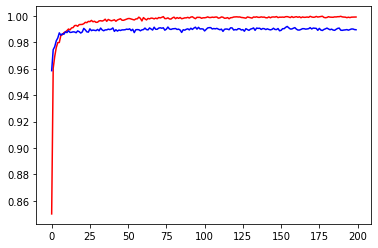

In [9]:
print(type(history))   # <class 'keras.callbacks.History'>
print(history.history.keys())  # dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.show()

In [7]:
# print(history)   # History 객체
# 이렇게 학습된 model 자체를 저장할 수 있다!
# 모델의 구조 + 계산된 모든 weight,bias를 하나의 파일에 저장 할 수 있다!
# 확장자는 .h5 (HDF5) 형식

model.save('/content/drive/MyDrive/Colab임시폴더/mnist_model_save/my_mnist_model.h5')

In [8]:
# model을 이용한 evaluation(평가)
model.evaluate(norm_test_x_data.reshape(-1,28,28,1), test_t_data)
#         loss               accuracy
# [0.11904290318489075, 0.9903967976570129]

394/394 [==============================] - 2s 6ms/step - loss: 0.1190 - accuracy: 0.9904


[0.11904290318489075, 0.9903967976570129]

In [5]:
# 저장된 모델을 불러와서
# 성능 평가를 진행해보자!
from tensorflow.keras.models import load_model

new_model = load_model('/content/drive/MyDrive/Colab임시폴더/mnist_model_save/my_mnist_model.h5')

# model을 이용한 evaluation(평가)
new_model.evaluate(norm_test_x_data.reshape(-1,28,28,1), test_t_data)
#         loss               accuracy
# [0.11904290318489075, 0.9903967976570129]

394/394 [==============================] - 5s 7ms/step - loss: 0.1190 - accuracy: 0.9904


[0.11904290318489075, 0.9903967976570129]

In [9]:
# model 학습(ckpt, earlyStopping callback 포함)

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# checkpoint 설정
# epoch마다 checkpoint 파일을 따로 만든다. 4자리의 digit 숫자로
checkpoint_path = '/content/drive/MyDrive/Colab임시폴더/mnist_model_save/cp-{epoch:04d}.ckpt'
cp_callback = ModelCheckpoint(checkpoint_path,
                              save_weights_only=True,
                              period=5,    # 5번 epoch마다 저장
                              verbose=1)   # 저장이 될 때마다 화면에 출력

# earlyStopping
es = EarlyStopping(monitor='val_loss',
                   min_delta=0.001,   # 0.001은 떨어져야 정상
                                      # 생략하면 값이 떨어지면 유효한 것을 판단
                   patience=5,        # 5번 연속 값이 좋아지지 않으면 그만
                   verbose=1,
                   mode='auto',
                   restore_best_weights=True)

# loss값과, accuracy 값이 dictionary 형태로 저장된다.
# norm_train_x_data 이 학습 데이터의 일부를 validation data로 활용해서
# 학습이 진행될 때(epoch마다) 평가를 같이 진행!
# 평가는 train data에 대한 loss와 accuracy,
#        valid data에 대한 loss와 accuracy
history = model.fit(norm_train_x_data.reshape(-1,28,28,1),
                    train_t_data,
                    epochs=50,        # epoch을 200번 수행
                    batch_size=100,   # 데이터 100개씩 순차적으로 실행
                    verbose=1,        # 출력 보이게
                    validation_split=0.3,   # input data의 30%를 valid로 사용(epoch마다)
                    callbacks=[cp_callback, es])

Epoch 1/50
206/206 [==============================] - 3s 16ms/step - loss: 0.0057 - accuracy: 0.9984 - val_loss: 0.0586 - val_accuracy: 0.9904
Epoch 2/50
206/206 [==============================] - 3s 12ms/step - loss: 0.0079 - accuracy: 0.9973 - val_loss: 0.0617 - val_accuracy: 0.9889
Epoch 3/50
206/206 [==============================] - 2s 12ms/step - loss: 0.0052 - accuracy: 0.9979 - val_loss: 0.0592 - val_accuracy: 0.9880
Epoch 4/50
206/206 [==============================] - 2s 12ms/step - loss: 0.0059 - accuracy: 0.9981 - val_loss: 0.0626 - val_accuracy: 0.9900
Epoch 5/50
203/206 [============================>.] - ETA: 0s - loss: 0.0073 - accuracy: 0.9976
Epoch 5: saving model to /content/drive/MyDrive/Colab임시폴더/mnist_model_save/cp-0005.ckpt
206/206 [==============================] - 3s 13ms/step - loss: 0.0072 - accuracy: 0.9977 - val_loss: 0.0633 - val_accuracy: 0.9889
Epoch 6/50
206/206 [==============================] - 3s 13ms/step - loss: 0.0054 - accuracy: 0.9982 - val

#Fashion MNIST

In [11]:
%reset
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
# 입력 Layer로 사용되는 Flatten layer, 출력, hidden layer로 사용되는 Dense layer
from tensorflow.keras.layers import Flatten, Dense
# Convolution, Pooling, Dropout-overfitting을 막기위함
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [14]:
# Raw Data Loading
train_df = pd.read_csv('/content/drive/MyDrive/Colab임시폴더/fashion_mnist/fashion-mnist_train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Colab임시폴더/fashion_mnist/fashion-mnist_test.csv')
display(train_df.head())
display(test_df.head())

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,9,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,6,0,0,0,0,0,0,0,5,0,...,0.0,0.0,0.0,30.0,43.0,0.0,0.0,0.0,0.0,0.0
3,0,0,0,0,1,2,0,0,0,0,...,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,3,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# x_data와 t_data로 나누기
train_x_data = train_df.drop('label', axis=1, inplace=False)
train_t_data = train_df['label']
test_x_data = test_df.drop('label', axis=1, inplace=False)
test_t_data = test_df['label']

# 정규화
scaler = MinMaxScaler()
scaler.fit(train_x_data)
norm_train_x_data = scaler.transform(train_x_data)
norm_test_x_data = scaler.transform(test_x_data)

In [16]:
# Keras 구현
# model 구현
model = Sequential()

model.add(Conv2D(filters=32,
                 kernel_size=(3,3),   # filter size
                 activation='relu',
                 input_shape=(28,28,1),   # 입력 image size, filter 개수
                 padding='valid',   # 원본에서 사이즈가 줄어든다.
                 strides=(1,1)))

model.add(MaxPooling2D(pool_size=(2,2)))  # stride는 알아서 pool_size와 동일하게 잡는다.

# print(model.summary())   # 내가 만든 모델의 요약정보를 볼 수 있다.

model.add(Conv2D(filters=64,
                 kernel_size=(3,3),   # filter size
                 activation='relu',
                 # 입력으로 들어오는 값을 알아서 처리 -> input_shape 명시가 필요 없다.
                 padding='valid',   # 원본에서 사이즈가 줄어든다.
                 strides=(1,1)))

model.add(MaxPooling2D(pool_size=(2,2)))  # stride는 알아서 pool_size와 동일하게 잡는다.

model.add(Conv2D(filters=64,
                 kernel_size=(3,3),   # filter size
                 activation='relu',
                 # 입력으로 들어오는 값을 알아서 처리 -> input_shape 명시가 필요 없다.
                 padding='valid',   # 원본에서 사이즈가 줄어든다.
                 strides=(1,1)))

# print(model.summary())

model.add(Flatten())
model.add(Dropout(rate=0.5))   # 형태는 유지하되 연산을 수행하는 노드를 반으로 줄인다.
model.add(Dense(units=256,   # 256개의 node를 가지는 hidden layer
                activation='relu'))

model.add(Dense(units=10,   # 10개의 Class(node)를 가지는 Output layer
                activation='softmax'))

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 flatten_1 (Flatten)         (None, 576)              

In [17]:
# model 실행 옵션
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [18]:
# model 학습

# loss값과, accuracy 값이 dictionary 형태로 저장된다.
# norm_train_x_data 이 학습 데이터의 일부를 validation data로 활용해서
# 학습이 진행될 때(epoch마다) 평가를 같이 진행!
# 평가는 train data에 대한 loss와 accuracy,
#        valid data에 대한 loss와 accuracy
history = model.fit(norm_train_x_data.reshape(-1,28,28,1),
                    train_t_data,
                    epochs=200,       # epoch을 200번 수행
                    batch_size=100,   # 데이터 100개씩 순차적으로 실행
                    verbose=1,        # 출력 보이게
                    validation_split=0.3)   # input data의 30%를 valid로 사용(epoch마다)


Epoch 1/200
203/203 [==============================] - 4s 17ms/step - loss: 0.8575 - accuracy: 0.6812 - val_loss: nan - val_accuracy: 0.7703
Epoch 2/200
203/203 [==============================] - 3s 13ms/step - loss: 0.5311 - accuracy: 0.7980 - val_loss: nan - val_accuracy: 0.8260
Epoch 3/200
203/203 [==============================] - 2s 11ms/step - loss: 0.4601 - accuracy: 0.8294 - val_loss: nan - val_accuracy: 0.8448
Epoch 4/200
203/203 [==============================] - 2s 11ms/step - loss: 0.4210 - accuracy: 0.8438 - val_loss: nan - val_accuracy: 0.8636
Epoch 5/200
203/203 [==============================] - 2s 12ms/step - loss: 0.3896 - accuracy: 0.8574 - val_loss: nan - val_accuracy: 0.8706
Epoch 6/200
203/203 [==============================] - 2s 12ms/step - loss: 0.3663 - accuracy: 0.8644 - val_loss: nan - val_accuracy: 0.8776
Epoch 7/200
203/203 [==============================] - 2s 12ms/step - loss: 0.3483 - accuracy: 0.8715 - val_loss: nan - val_accuracy: 0.8812
Epoch 8/200
2

In [19]:
# model을 이용한 evaluation(평가)
model.evaluate(norm_test_x_data.reshape(-1,28,28,1), test_t_data)
#         loss               accuracy
# [0.11904290318489075, 0.9903967976570129]
# [0.5086526274681091, 0.9111999869346619]

313/313 [==============================] - 1s 4ms/step - loss: 0.5087 - accuracy: 0.9112


[0.5086526274681091, 0.9111999869346619]